## Using BERT to Classify text 



In [1]:
import os
import random
import datetime
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vectors, build_vocab_from_iterator


USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

seed = 30255    
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if USE_CUDA:
    torch.cuda.manual_seed(seed)

COLAB = True

if COLAB:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    PATH = "gdrive/Shareddrives/Adv ML Project/Data/"
else:
    # Change path to appropriate location
    PATH = "/Users/kilaf/OneDrive - The University of Chicago/CAPP255/Project"
    

Using cuda.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Step 1: Load in pre-processed data and split into train, validation and test datasets using seed 30255

In [2]:
df = pd.read_csv(os.path.join(PATH + "preprocessed_data.csv"))

In [3]:
len(df)

6115

Converting the classes we want to classify to integers

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df['CLASS'])

decoded_labels = le.inverse_transform(labels)
print(set(labels), set(decoded_labels))

{0, 1, 2, 3, 4} {'Fossil Fuels', 'Energy Storage, Conversion, and Utilization', 'Fission and Nuclear Technologies', 'Renewable Energy Sources', 'Environmental Sciences'}


Using the BERT_TOKENIZED column to create our dataloader with the intergerized labels

In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from transformers import BertTokenizer

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

In [7]:
def tokenize_text(text):
    """
    Truncating the text to 512 for consistency's sake
    """
    return tokenizer.encode_plus(text,
                                  add_special_tokens=True,
                                  max_length=320,
                                  padding='max_length',
                                  return_attention_mask=True,
                                  return_tensors='pt',
                                  truncation=True)

tokenized_text = df['DESCRIPTION'].apply(tokenize_text)

In [8]:
#

In [9]:
from torch.utils.data import DataLoader, TensorDataset

# create DataLoader - need to stack the lists of tensors into one tensor
input_ids = torch.stack([row['input_ids'] for row in tokenized_text])
attention_mask = torch.stack([row['attention_mask'] for row in tokenized_text])

# Concatenating the Embeddings, Attention Mask and Labels
dataset = TensorDataset(input_ids, attention_mask, torch.tensor(labels, dtype=torch.long))

In [10]:
# compute train/validation/test split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# split dataset randomly into train/validation/test sets
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# create data loaders for each set
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [11]:
import torch.nn as nn
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels))
device = torch.device('cuda')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Step 2: Model Training

In [12]:
def train_model(model, train_data_loader, optimizer):
    model.train()

    for batch in train_data_loader:
        input_ids, attention_mask, labels = batch
        if USE_CUDA:
                input_ids, attention_mask, labels = input_ids.squeeze(1).cuda(), attention_mask.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = torch.nn.functional.cross_entropy(outputs.logits, labels)

        loss.backward()
        optimizer.step()

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
def validate(model, data_loader, num_classes):
    model.eval() # set model to evaluation mode
    
    # initialize performance metrics
    num_correct = 0
    num_samples = 0
    losses = []
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes
    
    # create empty lists for storing predicted labels and true labels
    all_preds = []
    all_labels = []
    
    # iterate over batches in validation set
    for batch in data_loader:
        # extract inputs and targets from batch
        input_ids, attention_mask, labels = batch
        if USE_CUDA:
            input_ids, attention_mask, labels = input_ids.squeeze(1).cuda(), attention_mask.cuda(), labels.cuda()

        # compute model outputs and loss
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = torch.nn.functional.cross_entropy(outputs.logits, labels)
        
        # update performance metrics
        losses.append(loss.item())
        _, preds = torch.max(outputs.logits, dim=1)
        num_correct += (preds == labels).sum().item()
        num_samples += labels.size(0)
        
        for i in range(num_classes):
            true_positives[i] += ((preds == i) & (labels == i)).sum().item()
            false_positives[i] += ((preds == i) & (labels != i)).sum().item()
            false_negatives[i] += ((preds != i) & (labels == i)).sum().item()
        
        # append predicted labels and true labels to the lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # compute average loss and accuracy
    avg_loss = sum(losses) / len(losses)
    accuracy = num_correct / num_samples
    
    # compute precision, recall, and F1 score for each class
    precision = []
    recall = []
    f1_score = []
    confusion_matrices = []
    for i in range(num_classes):
        precision.append(true_positives[i] / (true_positives[i] + false_positives[i] + 1e-10))
        recall.append(true_positives[i] / (true_positives[i] + false_negatives[i] + 1e-10))
        f1_score.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10))

                    # create confusion matrix for the current class
    
    print(f'Validation Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1_score}')

    # create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    

    return avg_loss, accuracy, precision, recall, f1_score, cm

In [15]:
num_epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()
val_loss = []
val_acc = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # train model on training set
    train_model(model, train_loader, optimizer)
    
    # validate model on validation set
    avg_loss, accuracy, precision, recall, f1_score, cm = validate(model, val_loader, 5)
    val_loss.append(avg_loss)
    val_acc.append(accuracy)

Epoch 1/5
Validation Loss: 4.5989 | Accuracy: 0.2879
Precision: [0.9199999999963201, 0.9285714285647959, 0.23313609467452862, 0.9393939393910927, 0.0]
Recall: [0.12169312169305731, 0.07262569832398177, 0.9999999999994924, 0.1565656565655775, 0.0]
F1 Score: [0.2149532710072015, 0.13471502589314077, 0.37811900188865, 0.26839826837354624, 0.0]
Confusion Matrix:
[[ 23   0 166   0   0]
 [  0  13 166   0   0]
 [  0   0 197   0   0]
 [  0   1 166  31   0]
 [  2   0 150   2   0]]
Epoch 2/5
Validation Loss: 2.1750 | Accuracy: 0.6260
Precision: [0.7823529411760104, 0.7872340425526332, 0.43693693693683855, 0.839506172838988, 0.0]
Recall: [0.7037037037033315, 0.620111731843229, 0.984771573603561, 0.68686868686834, 0.0]
F1 Score: [0.7409470751586409, 0.6937499999502714, 0.6053042121257222, 0.7555555555056358, 0.0]
Confusion Matrix:
[[133   5  45   6   0]
 [  4 111  55   9   0]
 [  1   2 194   0   0]
 [  4   4  54 136   0]
 [ 28  19  96  11   0]]
Epoch 3/5
Validation Loss: 1.2066 | Accuracy: 0.7710


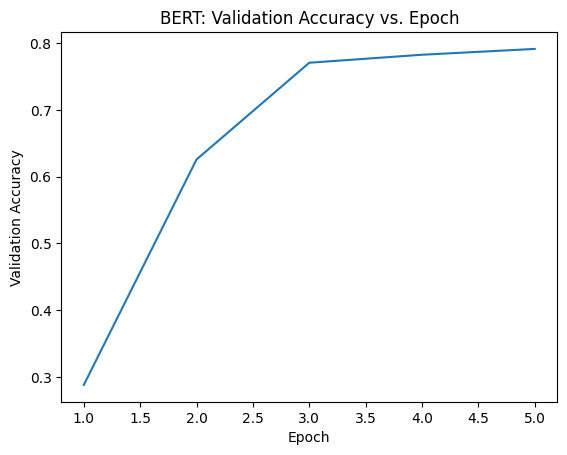

In [16]:
import matplotlib.pyplot as plt

# plot validation loss
plt.plot(range(1, num_epochs+1), val_acc)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('BERT: Validation Accuracy vs. Epoch')
plt.show()

In [17]:
avg_loss, accuracy, precision, recall, f1_score, cm = validate(model, test_loader, 5)

Validation Loss: 0.6722 | Accuracy: 0.8148
Precision: [0.8857142857136532, 0.8961038961033143, 0.8465116279065831, 0.7688442211051413, 0.7190476190472767]
Recall: [0.7848101265817818, 0.7301587301583439, 0.8965517241374894, 0.8499999999995278, 0.8031914893612749]
F1 Score: [0.8322147650502951, 0.8046647229821214, 0.8708133970788112, 0.8073878627465334, 0.7587939697990178]
Confusion Matrix:
[[124   3   4   8  19]
 [  3 138  15  15  18]
 [  3   5 182   2  11]
 [  4   6   6 153  11]
 [  6   2   8  21 151]]


In [18]:
print(set(labels), set(decoded_labels))

{0, 1, 2, 3, 4} {'Fossil Fuels', 'Energy Storage, Conversion, and Utilization', 'Fission and Nuclear Technologies', 'Renewable Energy Sources', 'Environmental Sciences'}
